In [31]:
from models import scribbler 
from models import discriminator
%load_ext autoreload
%autoreload 2

In [32]:
class wrap_tensor(object):
    def __new__(self, tensor, use_gpu=0):
        
        if use_gpu:
            tensor = tensor.gpu()
        
        return Variable(tensor)


## Transforms moved to utils

In [33]:
class toLAB(object):
    
    def __init__(self):
        self.space = 'LAB'
        
    def __call__(self, image ):
        lab_img = color.rgb2lab(np.array(img)/255.0)
        return lab_img
    
class toRGB(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, img):
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        rgb_img = color.lab2rgb(np.array(npimg))
        return rgb_img
    
class toTensor(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, pic):
        img = torch.from_numpy(pic.transpose((2, 0, 1)))
        return img
        

## Tests for color space transformations

In [34]:
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import visualize
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import display
import torchvision.models as models
from dataloader import imfol

%matplotlib inline

### Pretrained model

In [7]:
feat_model=models.vgg19(pretrained=True)

In [8]:
feat_model=feat_model.double()

In [10]:
lab_var = Variable(lab_tensor.unsqueeze(0),requires_grad=True)
A,B,C=torch.chunk(lab_var,3,dim=1)

NameError: name 'lab_tensor' is not defined

In [9]:
AAA=torch.cat((A,A,A),1)

NameError: name 'A' is not defined

In [64]:
out=feat_model.features(AAA)

In [107]:
layer = nn.Conv2d(3,32,3,2,1).double()
out=layer(AAA.double())

In [114]:
out.backward(Variable(torch.ones(1,32,320,270).double()))

In [35]:
A=imfol.make_dataset('/home/wxian3/training_handbags_pretrain/')

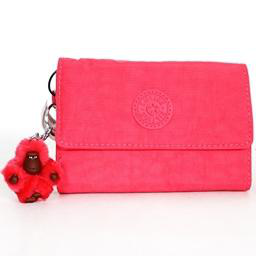

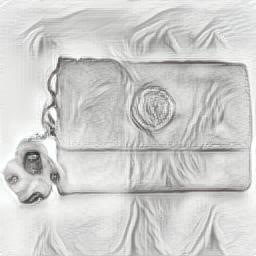

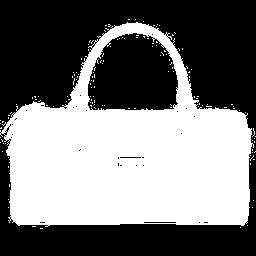

In [36]:
from PIL import Image
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

@interact(x=100)
def disp_set(x):
    display(Image.open(A[x][0]))
    display(Image.open(A[x][1]))
    display(Image.open(A[x][2]))

In [37]:
from torch.utils.data import DataLoader
from dataloader.imfol import ImageFolder, make_dataset
from utils import transforms as custom_trans
import torchvision.transforms as tforms

In [38]:
ts=tforms.Compose([custom_trans.toLAB(), custom_trans.toTensor()])
rgbify = custom_trans.toRGB()
dset = ImageFolder('/home/wxian3/training_handbags_pretrain/',ts)
dataloader=DataLoader(dataset=dset, batch_size=2, shuffle=True)

In [39]:
a,b = dataloader.__iter__().__next__()

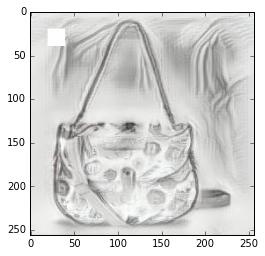

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import utils.transforms as utforms
%matplotlib inline

npimg = np.transpose(b[0].numpy()/100, (1, 2, 0))

ap=rgbify(b[0])
bp=rgbify(a[0])

#plt.imshow(bp)
#plt.hold('on')
gp=np.copy(ap)
gp[20:40,20:40,:]=bp[20:40,20:40,:]
plt.imshow(gp,cmap='gray')

In [10]:
import utils
reload(utforms)

<module 'utils.transforms' from 'utils/transforms.py'>

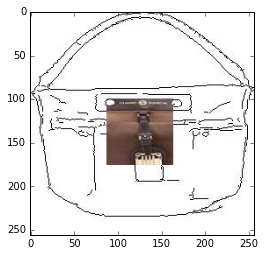

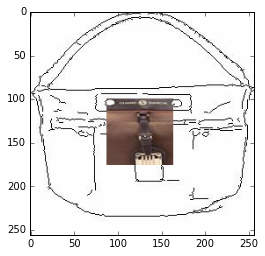

In [41]:
from utils.visualize import vis_patch
a,b = dataloader.__iter__().__next__()
@interact(xcenter=[50,200],ycenter=[50,200],size=[10,100])
def move_patch(xcenter,ycenter,size):
    #gp=np.copy(ap)
    #gp[xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2,:]=bp[xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2,:]
    gp = vis_patch(a,b,xcenter,ycenter,size)
    
    anorm = utforms.normalize_lab(a)
    bnorm = utforms.normalize_lab(b)
    
    arecon = utforms.denormalize_lab(anorm)
    brecon = utforms.denormalize_lab(bnorm)
    
    gprecon = vis_patch(arecon,brecon,xcenter,ycenter,size)
    
    plt.figure(1)
    plt.imshow(gp)
    
    plt.figure(2)
    plt.imshow(gprecon)

In [47]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [53]:
from models import scribbler, discriminator
import torch.optim as optim

netG=scribbler.Scribbler(3,3,32)
netD=discriminator.Discriminator(3,32)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
criterion_l1 = nn.L1Loss()

input_skg = torch.FloatTensor(2, 3, 256, 256)
output_img = torch.FloatTensor(2, 3, 256, 256)
label = torch.FloatTensor(2)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [57]:
netG(Variable(torch.Tensor(2,3,256,256))).data.size()

torch.Size([2, 3, 256, 256])

In [63]:
for epoch in range(5):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        a, b = data
        input_skg.resize_as_(a.float()).copy_(a)
        output_img.resize_as_(a.float()).fill_(real_label)
        inputv = Variable(input_skg)
        outputv = Variable(output_img)
        labelv = Variable(label)
        print labelv.data.size()
        
        output = netD(inputv)
        #errD_real = criterion(output, labelv)
        #errD_real.backward()
        #D_x = output.data.mean()

        # train with fake
        #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        #noisev = Variable(noise)
        fake = netG(inputv)
        output = netD(fake.detach())
        label.resize_(output.data.size())
        labelv = Variable(label.fill_(fake_label))
        
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        #errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        err_recon = criterion(fake, outputv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
        #      % (epoch, opt.niter, i, len(dataloader),
        #         errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        #if i % 100 == 0:
        #    vutils.save_image(real_cpu,
        #            '%s/real_samples.png' % opt.outf,
        #            normalize=True)
        #    fake = netG(fixed_noise)
        #    vutils.save_image(fake.data,
        #            '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
        #            normalize=True)

    # do checkpointing
    #torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    #torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

torch.Size([2, 1, 14, 14])


NameError: name 'errG' is not defined

In [27]:
a=torch.cat((L,L,L),1).div(100)

In [ ]:
feat_model.features(a)

In [32]:
feat_mean = torch.zeros(a.size())
feat_var = torch.zeros(a.size())

feat_mean[:,0,:,:]=0.485
feat_mean[:,1,:,:]=0.456
feat_mean[:,2,:,:]=0.406

feat_var[:,0,:,:]=0.229
feat_var[:,1,:,:]=0.224
feat_var[:,2,:,:]=0.225


In [40]:
processed_img = (a-feat_mean.double())/feat_var.double()

In [41]:
out=feat_model.features(wrap_tensor(processed_img))